<a href="https://colab.research.google.com/github/Oshada-Kasun/skin-cancer-detection/blob/main/notebooks/VGG_19_partial_dataset_with_heatmaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin-Cancer Classification Using ISIC2020 Image Dataset
Skin cancers can be divided into two major groups - melanoma and non-melanoma. The melanoma is considered to be more serious as it can quickly spread to other organs if not treated at an early stage. There is a necessity for early detection of skin cancer, particularly melanoma, to ensure the patient survival rates in the face of an ever growing number of cases every year.

So, the aim of this project is to develop deep neural network architecture that can efficiently identify the melanoma and non-melanoma categories of skin cancer.

In [ ]:
# Load Libraries
import os
from matplotlib import pyplot as plt
from IPython import display

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

import cv2


In [ ]:
#Import the ISIC2020 Training GroundTruth_v2 csv file
df_url = 'https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth_v2.csv'
df = pd.read_csv(df_url)
df.head()

,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,IL_7972535,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,IL_4649854,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,IL_9087444,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,IL_4255399,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,IL_6898037,female,55.0,upper extremity,unknown,benign,0


In [ ]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   lesion_id                      33126 non-null  object 
 3   sex                            33061 non-null  object 
 4   age_approx                     33058 non-null  float64
 5   anatom_site_general_challenge  32599 non-null  object 
 6   diagnosis                      33126 non-null  object 
 7   benign_malignant               33126 non-null  object 
 8   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 2.3+ MB


(33126, 9)

In [ ]:
df.target.value_counts()

0    32542
1      584
Name: target, dtype: int64

In [ ]:
df_ben = df[df.target == 0]
df_mal = df[df.target == 1]

In [ ]:
df_ben.shape, df_mal.shape

((32542, 9), (584, 9))

In [ ]:
# Malignant samples
print("Total malignant samples:", df_mal.shape)

# select malignant samples for training
df_mal_te = df_mal.sample(80, random_state=42)
print("Randomly selected malignant samples for testing:", df_mal_te.shape)
df_mal_new1 = df_mal.drop(df_mal_te.index)
#print(df_mal_new1.shape)

# select malignant samples for validation
df_mal_va = df_mal_new1.sample(120, random_state=42)
print("Randomly selected malignant samples for validation:", df_mal_va.shape)

# select malignant samples for training
df_mal_remain = df_mal_new1.drop(df_mal_va.index)
df_mal_tr = df_mal_remain.sample(len(df_mal_remain), random_state=42)
print("Randomly selected remaining malignant samples for training:", df_mal_tr.shape)


Total malignant samples: (584, 9)
Randomly selected malignant samples for testing: (80, 9)
Randomly selected malignant samples for validation: (120, 9)
Randomly selected remaining malignant samples for training: (384, 9)


In [ ]:
# Benign samples
print("Total benign samples:", df_ben.shape)

# select benign samples for training
df_ben_tr = df_ben.sample(2304, random_state=42)
print("Randomly selected benign samples for training:", df_ben_tr.shape)
df_ben_new1 = df_ben.drop(df_ben_tr.index)
#print(df_ben_new1.shape)

# select benign samples for validation
df_ben_va = df_ben_new1.sample(240, random_state=42)
print("Randomly selected benign samples for validation:", df_ben_va.shape)
df_ben_new2 = df_ben_new1.drop(df_ben_va.index)
#print(df_ben_new2.shape)

# select benign samples for testing
df_ben_te = df_ben_new2.sample(160, random_state=42)
print("Randomly selected benign samples for testing:", df_ben_te.shape)
df_ben_new3 = df_ben_new2.drop(df_ben_te.index)
print("Remaining beningn samples:", df_ben_new3.shape)


Total benign samples: (32542, 9)
Randomly selected benign samples for training: (2304, 9)
Randomly selected benign samples for validation: (240, 9)
Randomly selected benign samples for testing: (160, 9)
Remaining beningn samples: (29838, 9)


In [ ]:
df_train = pd.concat([df_ben_tr, df_mal_tr], axis=0)
df_train = df_train.sample(len(df_train), random_state=42)
df_train = df_train.reset_index(drop=True)
print("Number of bening and malignant samples in the training set:")
print(df_train.target.value_counts())
df_train

Number of bening and malignant samples in the training set:
0    2304
1     384
Name: target, dtype: int64


,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_1361355,IP_3523452,IL_9361178,female,20.0,lower extremity,unknown,benign,0
1,ISIC_4384199,IP_0718832,IL_2254691,female,50.0,torso,unknown,benign,0
2,ISIC_7764144,IP_1769689,IL_9362044,male,30.0,lower extremity,unknown,benign,0
3,ISIC_2008230,IP_7160012,IL_1472076,male,60.0,torso,unknown,benign,0
4,ISIC_1474461,IP_9921339,IL_0420982,female,55.0,torso,melanoma,malignant,1
...,...,...,...,...,...,...,...,...,...
2683,ISIC_1429439,IP_8140841,IL_7168087,male,75.0,upper extremity,unknown,benign,0
2684,ISIC_0338377,IP_2153088,IL_1401429,female,30.0,torso,unknown,benign,0
2685,ISIC_5869383,IP_3868067,IL_2152211,male,45.0,upper extremity,unknown,benign,0
2686,ISIC_6213445,IP_7211398,IL_6089677,male,50.0,torso,unknown,benign,0


In [ ]:
df_val = pd.concat([df_ben_va, df_mal_va], axis=0)
df_val = df_val.sample(len(df_val), random_state=42)
df_val = df_val.reset_index(drop=True)
print("Number of bening and malignant samples in the validation set:")
print(df_val.target.value_counts())
df_val

Number of bening and malignant samples in the validation set:
0    240
1    120
Name: target, dtype: int64


,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_4926484,IP_4382720,IL_9022880,female,50.0,torso,unknown,benign,0
1,ISIC_2325146,IP_2613684,IL_9927992,male,50.0,lower extremity,unknown,benign,0
2,ISIC_6269166,IP_0059113,IL_4581908,female,75.0,upper extremity,melanoma,malignant,1
3,ISIC_4874581,IP_8154616,IL_2600000,female,80.0,lower extremity,melanoma,malignant,1
4,ISIC_4391904,IP_9299257,IL_5217634,female,45.0,upper extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...,...
355,ISIC_3808070,IP_7160012,IL_7203442,male,65.0,torso,unknown,benign,0
356,ISIC_1845271,IP_7622888,IL_2376877,male,30.0,lower extremity,unknown,benign,0
357,ISIC_3446357,IP_2101945,IL_2642487,male,65.0,upper extremity,melanoma,malignant,1
358,ISIC_6829008,IP_9635781,IL_3388373,female,50.0,lower extremity,melanoma,malignant,1


In [ ]:
df_test = pd.concat([df_ben_te, df_mal_te], axis=0)
df_test = df_test.sample(len(df_test), random_state=42)
df_test = df_test.reset_index(drop=True)
print("Number of bening and malignant samples in the validation set:")
print(df_test.target.value_counts())
df_test

Number of bening and malignant samples in the validation set:
0    160
1     80
Name: target, dtype: int64


,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_3237364,IP_5424227,IL_9595237,female,55.0,torso,unknown,benign,0
1,ISIC_1790808,IP_7785592,IL_1468669,male,40.0,lower extremity,unknown,benign,0
2,ISIC_3218193,IP_9689997,IL_2835143,female,55.0,head/neck,unknown,benign,0
3,ISIC_5580631,IP_1244021,IL_1553884,female,35.0,upper extremity,unknown,benign,0
4,ISIC_0998651,IP_0541183,IL_6546418,female,75.0,torso,unknown,benign,0
...,...,...,...,...,...,...,...,...,...
235,ISIC_0879020,IP_6936664,IL_8148867,female,70.0,upper extremity,unknown,benign,0
236,ISIC_5074129,IP_8534235,IL_9273693,female,60.0,lower extremity,unknown,benign,0
237,ISIC_6876344,IP_0091605,IL_3945334,female,45.0,torso,nevus,benign,0
238,ISIC_3159924,IP_2584339,IL_3564691,male,45.0,upper extremity,melanoma,malignant,1


In [ ]:
#Import training images form the ISIC202 website
!wget https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_JPEG.zip 

--2022-02-17 14:25:51--  https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_JPEG.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.205.97
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.205.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24707698022 (23G) [application/zip]
Saving to: ‘ISIC_2020_Training_JPEG.zip’

ISIC_2020_Training_ 100%[===================>]  23.01G  30.0MB/s    in 11m 1s  

2022-02-17 14:36:52 (35.7 MB/s) - ‘ISIC_2020_Training_JPEG.zip’ saved [24707698022/24707698022]



In [ ]:
!unzip ISIC_2020_Training_JPEG.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/ISIC_8710040.jpg  
  inflating: train/ISIC_4667975.jpg  
  inflating: train/ISIC_7672567.jpg  
  inflating: train/ISIC_1870377.jpg  
  inflating: train/ISIC_5941271.jpg  
  inflating: train/ISIC_0298093.jpg  
  inflating: train/ISIC_3830701.jpg  
  inflating: train/ISIC_0528791.jpg  
  inflating: train/ISIC_4167610.jpg  
  inflating: train/ISIC_9392704.jpg  
  inflating: train/ISIC_6084191.jpg  
  inflating: train/ISIC_0242801.jpg  
  inflating: train/ISIC_7763042.jpg  
  inflating: train/ISIC_2256519.jpg  
  inflating: train/ISIC_4575717.jpg  
  inflating: train/ISIC_9407667.jpg  
  inflating: train/ISIC_4187485.jpg  
  inflating: train/ISIC_4576846.jpg  
  inflating: train/ISIC_0736928.jpg  
  inflating: train/ISIC_5667461.jpg  
  inflating: train/ISIC_5708288.jpg  
  inflating: train/ISIC_3910037.jpg  
  inflating: train/ISIC_6009620.jpg  
  inflating: train/ISIC_3045489.jpg  
  inflating: train/ISIC_6405298.jpg  

In [ ]:
from tqdm import tqdm
from keras.preprocessing import image 

path_jpg = '/content/train/'

X_train_images_resized = []

for i in tqdm(df_train.image_name.values):
  img_name = path_jpg + i + '.jpg'
  img = image.load_img(img_name, target_size=(224,224))
  img = image.img_to_array(img)
  img = img/255.0
  X_train_images_resized.append(img)


100%|██████████| 2688/2688 [06:42<00:00,  6.69it/s]


In [ ]:
y_train_labels = df_train['target']
y_train_labels.shape

(2688,)

In [ ]:
len(X_train_images_resized)

2688

In [ ]:
# Data Augmentation for Malignant images
def augment_image(image):
    augmented_images = []
    vertical_flip = cv2.flip(image, 0)
    horizontal_flip = cv2.flip(image, 1)
    augmented_images.append(cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE))
    augmented_images.append(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE))
    augmented_images.append(cv2.rotate(image, cv2.ROTATE_180))
    augmented_images.append(vertical_flip)
    augmented_images.append(horizontal_flip)
    #augmented_images.append(cv2.rotate(vertical_flip, cv2.ROTATE_90_CLOCKWISE))
    #augmented_images.append(cv2.rotate(horizontal_flip, cv2.ROTATE_90_CLOCKWISE))
    return augmented_images

In [ ]:
for index, (_, row) in enumerate(df_train.iterrows()):
    if row['benign_malignant'] == 'malignant':
        augmented_images = augment_image(X_train_images_resized[index])
        X_train_images_resized.extend(augmented_images)
        y_train_labels = y_train_labels.append(pd.Series([1]*len(augmented_images)))

In [ ]:
y_train_labels.value_counts()

0    2304
1    2304
dtype: int64

In [ ]:
X_train = np.array(X_train_images_resized)
print("X_train shape is:", X_train.shape)

y_train = np.array(y_train_labels)
print("y_train shape is:", y_train.shape)

X_train shape is: (4608, 224, 224, 3)
y_train shape is: (4608,)


In [ ]:
X_val_images_resized = []

for i in tqdm(df_val.image_name.values):
  img_name = path_jpg + i + '.jpg'
  img = image.load_img(img_name, target_size=(224,224))
  img = image.img_to_array(img)
  img = img/255.0
  X_val_images_resized.append(img)

100%|██████████| 360/360 [00:50<00:00,  7.11it/s]


In [ ]:
X_val = np.array(X_val_images_resized)
print("X_val.shape:", X_val.shape)

y_val_labels = df_val['target']
y_val = np.array(y_val_labels)
print("y_val shape is:", y_val.shape)

X_val.shape: (360, 224, 224, 3)
y_val shape is: (360,)


In [ ]:
X_test_images_resized = []

for i in tqdm(df_test.image_name.values):
  img_name = path_jpg + i + '.jpg'
  img = image.load_img(img_name, target_size=(224,224))
  img = image.img_to_array(img)
  img = img/255.0
  X_test_images_resized.append(img)

100%|██████████| 240/240 [00:32<00:00,  7.29it/s]


In [ ]:
X_test = np.array(X_test_images_resized)
print("X_test shape is:", X_test.shape)

y_test_labels = df_test['target']
y_test = np.array(y_test_labels)
print("y_test shape is:", y_test.shape)

X_test shape is: (240, 224, 224, 3)
y_test shape is: (240,)


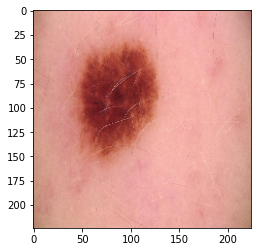

Image Class: 0
Maximum pixel value in an image = 1.0


In [ ]:
#display sample training image
index = 150
plt.imshow(X_train[index])
plt.show()
print(f"Image Class: {y_train[index]}")
print(f"Maximum pixel value in an image = {np.max(X_train[index])}")

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#cd /content/drive/MyDrive/FourthBrainMLECapstone/

In [ ]:
# Initialize Tensorboard to monitor changes in Model Loss 
#import datetime
#%load_ext tensorboard
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# Fine-tune and fit the VGG19 model
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.vgg19 import VGG19

base_vgg19_model = VGG19(weights='imagenet', include_top=False)

# get layers and add average pooling layer
x = base_vgg19_model.output
x = GlobalAveragePooling2D()(x)

# add fully-connected layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

# add output layer
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_vgg19_model.input, outputs=predictions)

# freeze pre-trained model area's layer
for layer in base_vgg19_model.layers:
    layer.trainable = False

# update the weight that are added
model.compile(optimizer='rmsprop', loss='binary_crossentropy')
model.fit(X_train, y_train)

# choose the layers from block4_pool, which are updated by training
for layer in model.layers[:12]:
    layer.trainable = False

for layer in model.layers[12:]:
    layer.trainable = True

# training
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


144/144 [==============================] - 23s 91ms/step - loss: 0.6563
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                       

## GridSearchCV with keras

In [ ]:
"""
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model():
  grid_model = model
  return grid_model

model1 = KerasClassifier(build_fn = create_model, verbose = 0)

# define the grid search parameters
batch_size = [32, 64]
epochs = [10, 20]

param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model1, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean , stdev , param in zip (means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

"""

'\nfrom keras.wrappers.scikit_learn import KerasClassifier\nfrom sklearn.model_selection import GridSearchCV\n\ndef create_model():\n  grid_model = model\n  return grid_model\n\nmodel1 = KerasClassifier(build_fn = create_model, verbose = 0)\n\n# define the grid search parameters\nbatch_size = [32, 64]\nepochs = [10, 20]\n\nparam_grid = dict(batch_size=batch_size, epochs=epochs)\ngrid = GridSearchCV(estimator=model1, param_grid=param_grid, n_jobs=1)\ngrid_result = grid.fit(X_train, y_train)\n\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean , stdev , param in zip (means, stds, params):\n  print("%f (%f) with: %r" % (mean, stdev, param))\n  \n'

In [ ]:
# Train the model 
#model_checkpoint = tf.keras.callbacks.ModelCheckpoint('skin_cancer_VGG19.hdf5', monitor='loss', verbose=1, save_best_only=True)

fit_history = model.fit(X_train, y_train, batch_size=32, validation_data = (X_val, y_val), epochs=18, verbose=1) #, callbacks=[model_checkpoint,tensorboard_callback])

Epoch 1/18
144/144 [==============================] - 25s 157ms/step - loss: 0.5132 - accuracy: 0.7491 - val_loss: 0.5192 - val_accuracy: 0.7500
Epoch 2/18
144/144 [==============================] - 21s 147ms/step - loss: 0.4505 - accuracy: 0.7938 - val_loss: 0.5764 - val_accuracy: 0.6889
Epoch 3/18
144/144 [==============================] - 21s 147ms/step - loss: 0.4109 - accuracy: 0.8142 - val_loss: 0.5395 - val_accuracy: 0.7278
Epoch 4/18
144/144 [==============================] - 21s 147ms/step - loss: 0.3873 - accuracy: 0.8292 - val_loss: 0.4921 - val_accuracy: 0.7556
Epoch 5/18
144/144 [==============================] - 21s 147ms/step - loss: 0.3675 - accuracy: 0.8435 - val_loss: 0.4804 - val_accuracy: 0.7778
Epoch 6/18
144/144 [==============================] - 21s 147ms/step - loss: 0.3581 - accuracy: 0.8464 - val_loss: 0.4796 - val_accuracy: 0.7861
Epoch 7/18
144/144 [==============================] - 21s 147ms/step - loss: 0.3375 - accuracy: 0.8559 - val_loss: 0.4960 - val_ac

In [ ]:
#Plotting the model Accurcay and Loss
def print_loss_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, color='red', label='Training loss')
    plt.plot(epochs, val_loss, color='green', label='Validation loss')
    #plt.plot([0, 1], [0, 1])
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return

def print_accuracy_history(training_history):
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, color='red', label='Training acc')
    plt.plot(epochs, val_acc, color='green', label='Validation acc')
    #plt.plot([0, 1], [0, 1])
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    return

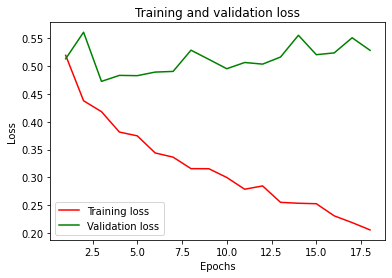

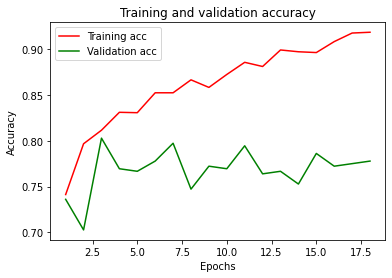

Classification report :
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       160
           1       0.70      0.71      0.71        80

    accuracy                           0.80       240
   macro avg       0.78      0.78      0.78       240
weighted avg       0.80      0.80      0.80       240

Confusion matrix : 
 [[136  24]
 [ 23  57]]


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print_loss_history(fit_history)
print_accuracy_history(fit_history)
y_pred = model.predict(X_test)
y_pred = y_pred.round().reshape(-1)
print("Classification report :")
print(classification_report(y_test, y_pred)) #, target_names=['Benign', 'Malignant'])
Confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix : \n", Confusion_matrix)

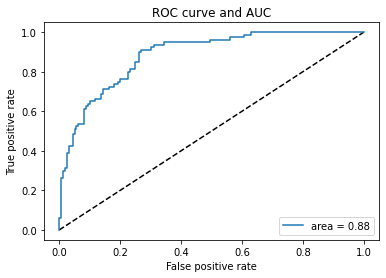

In [ ]:
# Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {:.2f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve and AUC')
plt.legend(loc='lower right')
plt.show()

y_test   y_pred
1 ------ 1.0
y_test   y_pred
0 ------ 0.0
y_test   y_pred
0 ------ 0.0
y_test   y_pred
1 ------ 0.0
y_test   y_pred
0 ------ 1.0
y_test   y_pred
0 ------ 0.0


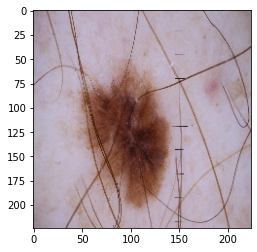

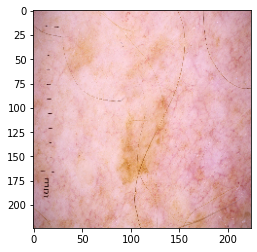

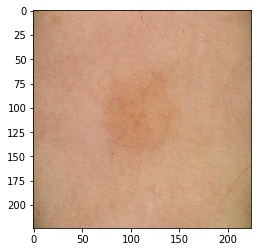

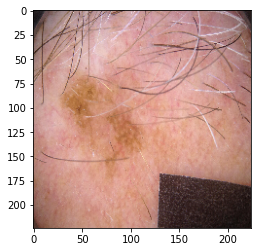

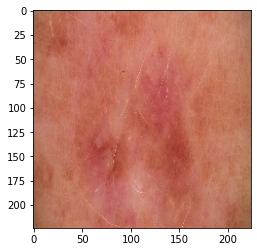

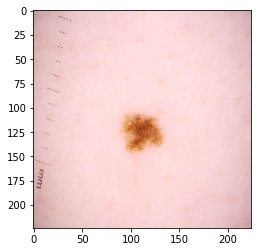

In [ ]:
# Display prediction for an image and it's actual label
for i in range(92,98):
  plt.subplots(1,1)
  plt.imshow(X_test[i])
  print('y_test   y_pred')
  print(y_test[i],'------', y_pred[i].round())

plt.show()

In [ ]:
#Visualize on tensorboard
#%tensorboard --logdir logs/fit

In [ ]:
# save the whole model
model.save('skin_cancer_vgg19_main_3.3_sgd.h5')

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
model_filename = "skin_cancer_vgg19_main_3.3_sgd.h5"
new_model = tf.keras.models.load_model(model_filename)

In [ ]:
# Saving images data as a numpy array
#with open('./images_data_X4686.npy', 'wb') as f:
#  np.save(f, X)

### Visualize the heatmap/saliency/features to demonstrate what regions of interest contribute to Benign and Malignant, respectively.

Reference:
https://keras.io/examples/vision/grad_cam/


In [ ]:
import matplotlib.cm as cm
from tensorflow import GradientTape
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
# Relevant layer names
classifier_layer_names = ['block5_pool', 'global_average_pooling2d', 'dense', 'dropout', 'dense_1']
last_conv_layer_name = 'block5_conv4'

In [ ]:
# Heatmap functions
def make_gradcam_heatmap(img, model, last_conv_layer_name, classifier_layer_names):
  img_array = np.expand_dims(img, axis=0)
  last_conv_layer = model.get_layer(last_conv_layer_name)
  last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

  classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
  x = classifier_input
  for layer_name  in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
  classifier_model = tf.keras.Model(classifier_input, x)

  with tf.GradientTape() as tape:
      # Compute activations of the last conv layer and make the tape watch it
      last_conv_layer_output = last_conv_layer_model(img_array)
      tape.watch(last_conv_layer_output)
      # Compute class predictions
      preds = classifier_model(last_conv_layer_output)
      top_pred_index = tf.argmax(preds[0])
      top_class_channel = preds[:, top_pred_index]

  grads = tape.gradient(top_class_channel, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  pooled_grads = pooled_grads.numpy()
  for i in range(pooled_grads.shape[-1]):
      last_conv_layer_output[:, :, i] *= pooled_grads[i]

  # The channel-wise mean of the resulting feature map
  # is our heatmap of class activation
  heatmap = np.mean(last_conv_layer_output, axis=-1)

  # For visualization purpose, we will also normalize the heatmap between 0 & 1
  heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
  return heatmap

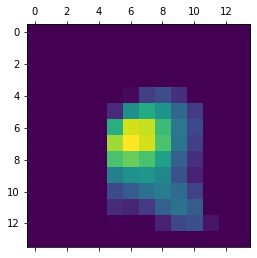

In [ ]:
# Use a test example to make sure our function works
heatmap = make_gradcam_heatmap(X_train[5], new_model, last_conv_layer_name, classifier_layer_names)

plt.matshow(heatmap)

### Demonstration
Now, we'll put it all together and show our heatmaps superimposed on top of some images, along with the class of that image, so we can see what the model is looking at for each class of image.

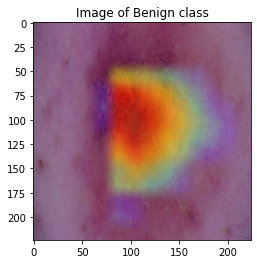

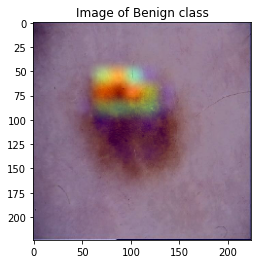

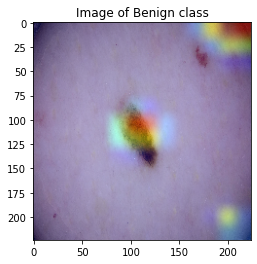

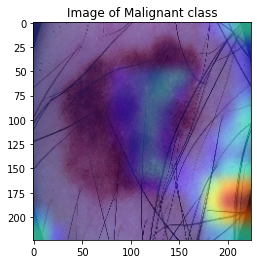

In [ ]:
class_dict = {0: "Benign", 1: "Malignant"}

for i in range(1, 5):
  img_class = class_dict.get(y_train[i])
  img = X_train[i]
  heatmap = make_gradcam_heatmap(img, model, 
                                 last_conv_layer_name, 
                                 classifier_layer_names)
  heatmap = np.uint8(255 * heatmap)
  img = img * 255.
  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.5 + img
  superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
  # Display Grad CAM
  plt.subplots(1,1)
  plt.title(f"Image of {img_class} class")
  plt.imshow(superimposed_img)

In [ ]:
# A function to display a heatmap
def show_heatmap(img):
  #class_dict = {0: "Benign", 1: "Malignant"}
  #img_class = class_dict.get(y_train[idx])
  #img = X_train[idx]
  heatmap = make_gradcam_heatmap(img, model, 
                                 last_conv_layer_name, 
                                 classifier_layer_names)
  heatmap = np.uint8(255 * heatmap)
  img = img * 255.
  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.5 + img
  superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
  print(superimposed_img)

  # Display Grad CAM
  plt.subplots(1,1)
  #plt.title(f"Image of {img_class} class")
  plt.imshow(superimposed_img)

In [ ]:
def read_image(img_name):
    img = image.load_img(img_name, target_size=(224,224))
    img = image.img_to_array(img)
    img = img/255.0
    return img

img_name = "train/ISIC_9123642.jpg"
input_image = read_image(img_name)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FF64EF15590>


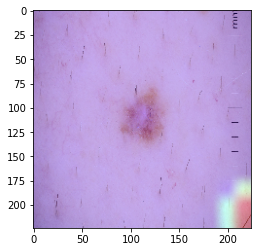

In [ ]:
show_heatmap(input_image)

## Examples of each class, with heatmaps
And now, we'll show off some of our heatmaps selectively. We'll find examples of each class in the dataset and print heatmaps for each one.

We'll look at the examples of each class from the first 30 entries in our training data and plot heatmaps for both classes.

In [ ]:
# Labels for first 20 items in training
class_labels = (y_train[:20]).reshape(-1,1)

### Benign

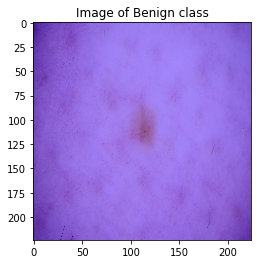

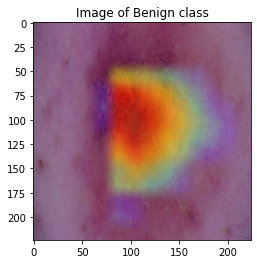

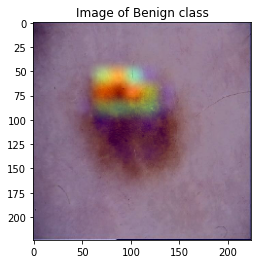

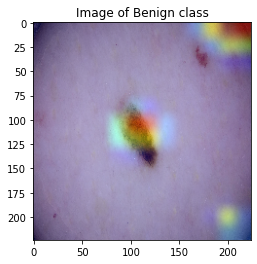

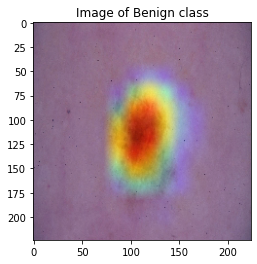

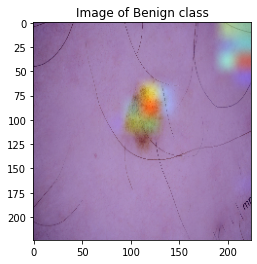

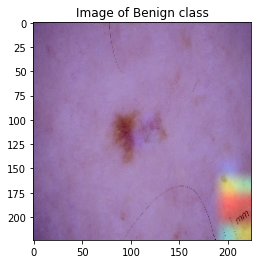

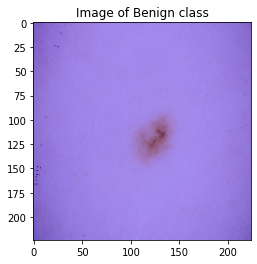

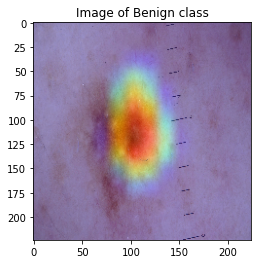

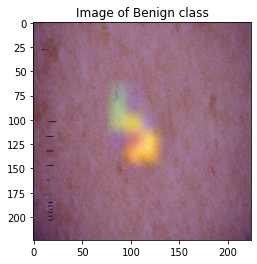

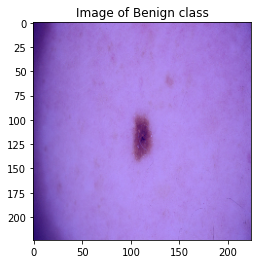

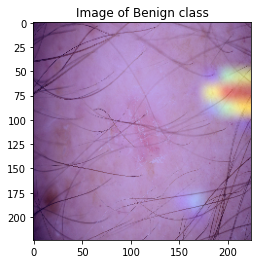

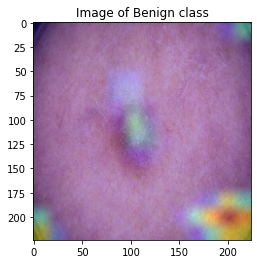

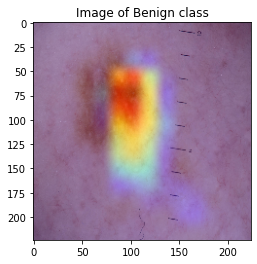

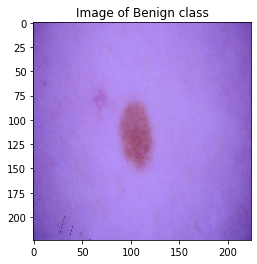

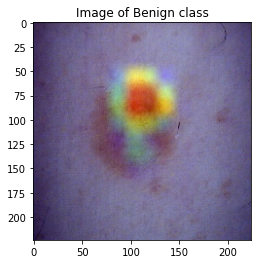

In [ ]:
# Benign heatmaps
for i in np.where(class_labels == 0)[0]:
  show_heatmap(i)

### Malignant

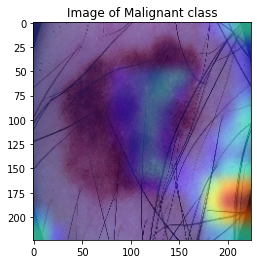

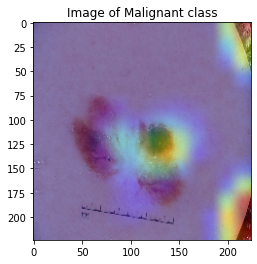

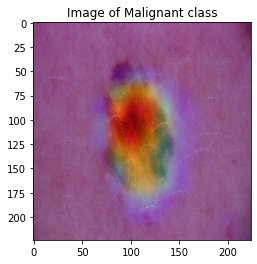

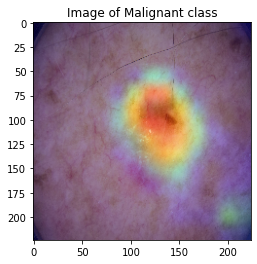

In [ ]:
# Malignant heatmaps
for i in np.where(class_labels == 1)[0]:
  show_heatmap(i)